# Building a Movie Recommender with Matrix Factorization

I aim to build a movie reccomender utilizing the movielens dataset which can be found [here](https://grouplens.org/datasets/movielens/). I chose the small dataset mostly for proof of concept purposes. The data consists of 100,000 ratings on 9,000 movies by 700 users. 

Matrix Factorization is a popular method used in reccomendation systems. In comparison with another popular method for reccomendation systems, user-item collaborative filtering, it is vastly more mathematical in theory than the latter. For example, the concept behind collaborative filtering is that it calculates users' similarities in the item space,it  then takes similar users's interest to make a recommendation for the target user. An example of a commonly used collaborative filtering method is a nearest neighbors model. Matrix factorization can be described as mapping features of user and items via linear combination to latent factor space, and then calculating the similarity via inner-product of latent user factor and latent item factor.

Two improvements that matrix factorization gives over collaborative filtering are that they scale better to larger datasets and are able to cope ignore noisy data better.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [278]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [30]:
len(ratings)

100004

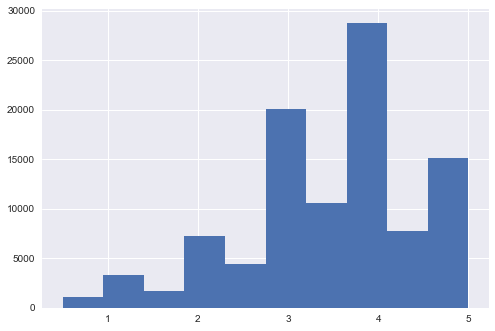

In [21]:
plt.hist(ratings['rating'])
plt.show()

In [6]:
# ratings skewed towards higher rating

movie_ratings = ratings.merge(movies, left_on='movieId', right_on='movieId', how='left')
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [7]:
# want the format of my ratings matrix to be one row per user and one column per movie
# use pivot table function from pandas

R_df = movie_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# convert to matrix and normalize

R = R_df.as_matrix()
movie_ratings_mean = np.mean(R, axis=1)
R_normalized = R - movie_ratings_mean.reshape(-1,1)

## Singular Value Decomposition

From a very basical level, my understanding of singular value decomposition is that matrix is decomposed in two simpler matrices along with a diagonal matrix. In the context of this problem are matrix that will be decomposed is our ratings matrix where the users are the rows, the movies are the columns, and the ratings are the values. To generate predictions, we then multiply the two matrices by the diagonal.

For this model I used the algorithm from scipy.sparse.linalg which allows us to tune the latent factors.

In [230]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_normalized, k = 50)

In [12]:
# function returns sigma as values and needs to be converted to diagonal matrix

sigma = np.diag(sigma)

In [13]:
# add back means to get actual ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + movie_ratings_mean.reshape(-1, 1)

In [14]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.054239,0.045130,-0.004835,-0.019817,-0.011284,0.041373,-0.007822,-0.017188,0.012246,0.037670,...,-0.005258,-0.005453,0.012369,-0.004991,-0.004639,-0.019055,0.021402,-0.006365,-0.006098,-0.004819
1,0.419835,1.406440,-0.188807,0.156658,0.268032,0.414698,0.052172,0.044728,-0.020198,2.220256,...,-0.005909,-0.003974,-0.012555,-0.003555,-0.002711,-0.071621,-0.016212,0.001047,-0.001468,-0.006577
2,1.345619,0.266505,-0.011962,0.012278,0.079508,0.090960,-0.122094,0.031327,-0.018023,0.141176,...,-0.002647,-0.002364,-0.010153,0.000277,-0.000116,-0.018063,-0.015761,0.010611,0.006792,-0.006357
3,1.133455,1.046982,0.141275,0.081841,-0.339675,-1.484659,-0.263096,-0.169750,-0.021862,1.611664,...,0.020805,0.000410,0.056040,-0.002817,-0.000767,0.159159,0.087519,-0.030854,-0.021279,0.048529
4,1.389578,1.466495,0.605557,-0.029647,0.729380,-0.118539,-0.026017,0.065577,-0.156655,0.307926,...,-0.007422,-0.011810,0.006644,-0.005159,-0.001249,-0.034658,0.016456,0.001710,-0.004166,-0.001864


After verification of the process, let's optimize our latent factors by tuning the k parameter as part of the function and miminize the RMSE.

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [135]:
# split the data into training and test set

train=movie_ratings.sample(frac=0.5,random_state=200)
test=movie_ratings.drop(train.index)

In [136]:
train.shape, test.shape

((50002, 6), (50002, 6))

In [26]:
def prepare_matrix(df):
    R_df = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    R = R_df.as_matrix()
    df_mean = np.mean(R, axis=1)
    R_normalized = R - df_mean.reshape(-1,1)
    return R_normalized

In [137]:
train_matrix, test_matrix = prepare_matrix(train), prepare_matrix(test)

In [138]:
train_matrix.shape, test_matrix.shape

((671, 7091), (671, 7094))

In [236]:
# tune the k parameter to observe the best possible rating

def rmse(matrix):

    rmse = []

    for k in range(2,20):
        U, sigma, Vt = svds(train_matrix, k=k)
        sigma = np.diag(sigma)

        matrix_mean = np.mean(matrix, axis=1)
        predicted_ratings = np.dot(np.dot(U, sigma), Vt) + matrix_mean.reshape(-1,1)

        df = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)
        preds_df = pd.DataFrame(predicted_ratings, columns=df.columns)
        preds_matrix = preds_df.as_matrix()
        
        preds_matrix_copy = preds_matrix.copy()
        matrix_copy = matrix.copy()
        matrix_copy.resize(671, 7091), preds_matrix_copy.resize(671, 7091)
        
        rmse.append(mean_squared_error(matrix_copy, preds_matrix_copy)**0.5)
        
    return rmse
    

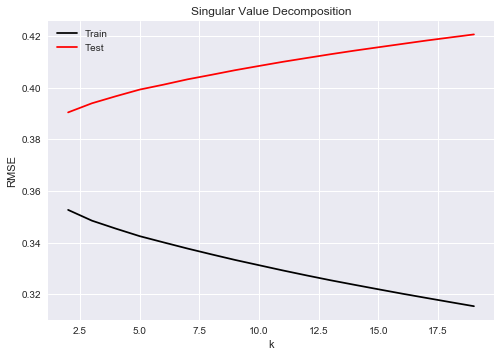

In [238]:
train_results, test_results = rmse(train_matrix), rmse(test_matrix)

ks = [i for i in range(2,20)]

plt.plot(ks, train_results, 'k', label="Train")
plt.plot(ks, test_results, 'r', label="Test")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.legend()
plt.title('Singular Value Decomposition')
plt.show()

A test error RMSE of 0.39 is solid considering the scale of the rating values ranges from 1 to 5, although considering our distribution of ratings, ratings are more likely to be 3 or higher. It is also clear that increasing the k parameter overfits the data.

## Alternating Least Squares

Similar to of SVD, my interpretation of ALS is also basic. From my understanding ALS aims to iteratively minimize the error between matrices, which in this context would be the users and the movies. In other words the algorithm will iterate to a convergence point where either the user matrix and the movie matrix are no longer changing or the change is small.

I chose to use the pyspark.mllib reccomendation library for this model.

In [34]:
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

sc = SparkContext()

# Load and parse the data
data = sc.textFile("ratings.csv")

In [57]:
data = data.map(lambda x: x.split(','))
header = data.first()
print(header)

['userId', 'movieId', 'rating', 'timestamp']


In [58]:
#Remove header
data2 = data.filter(lambda line: line!=header)
data2 = data2.map(lambda x : [x[i] for i in [0,1,2]])

In [275]:
ratings_RDD = data2.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [276]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings_RDD, rank, numIterations)

In [277]:
# Evaluate the model on training data
testdata = ratings_RDD.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings_RDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
RMSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()**0.5
print("Root Mean Squared Error = " + str(RMSE))

Root Mean Squared Error = 0.5237116219108433


It appears that SVD was superior in this setting. Now let's make actual predictions using it.

In [264]:
# create SVD model with optimized k

U, sigma, Vt = svds(R_normalized, k = 2)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + movie_ratings_mean.reshape(-1, 1)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,0.057189,0.023030,0.019834,0.005306,0.020338,0.044342,0.033434,0.004319,0.007188,0.025969,...,0.001833,-0.000091,-0.001182,-0.000253,-0.000293,-0.001090,-0.001687,-0.000341,-0.000274,0.003838
1,0.761520,0.295171,0.132782,0.011899,0.150914,0.397436,0.181426,0.002789,0.022093,0.333370,...,-0.012734,-0.021416,-0.019100,-0.021226,-0.020521,-0.022382,-0.017332,-0.022625,-0.022629,-0.002833
2,0.772993,0.303066,0.076526,-0.004262,0.100757,0.306172,0.052967,-0.011123,-0.002194,0.340539,...,-0.017014,-0.016447,-0.005000,-0.014988,-0.013614,-0.010710,0.001369,-0.016499,-0.016994,-0.016292
3,2.113548,0.824890,0.408936,0.053528,0.455933,1.159548,0.581165,0.027148,0.085971,0.930975,...,-0.020828,-0.049674,-0.048020,-0.049807,-0.048207,-0.055839,-0.045526,-0.053623,-0.053377,0.011352
4,1.283930,0.507922,0.144389,0.004094,0.183402,0.529831,0.117671,-0.007626,0.008886,0.569974,...,-0.018992,-0.019618,-0.002246,-0.017423,-0.015265,-0.011272,0.007501,-0.019901,-0.020636,-0.016244


In [292]:
def recommend_movies(predictions_df, userID, movies_df, ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # userId starts at 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # userId starts at 1
    
    # Get the user's data and merge in the movie information
    user_data = ratings_df[ratings_df['userId'] == userID]
    # sorting the values is key so we can look at the user's top movies easily
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has rated {1} movies.'.format(userID, user_full.shape[0]))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [293]:
already_rated, predictions = recommend_movies(preds_df, 7, movies, ratings, 10)

User 7 has rated 88 movies.


In [294]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
42,7,720,5.0,851868019,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
59,7,1196,5.0,851869034,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
68,7,1242,5.0,851868289,Glory (1989),Drama|War
65,7,1225,5.0,851868246,Amadeus (1984),Drama
64,7,1223,5.0,851868044,"Grand Day Out with Wallace and Gromit, A (1989)",Adventure|Animation|Children|Comedy|Sci-Fi
16,7,318,5.0,851868187,"Shawshank Redemption, The (1994)",Crime|Drama
62,7,1210,5.0,851869034,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
61,7,1198,5.0,851869035,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
13,7,260,5.0,851869062,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
86,7,1405,5.0,851866978,Beavis and Butt-Head Do America (1996),Adventure|Animation|Comedy|Crime


In [295]:
predictions.head(10)

,movieId,title,genres
251,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
488,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
496,608,Fargo (1996),Comedy|Crime|Drama|Thriller
443,527,Schindler's List (1993),Drama|War
2200,2858,American Beauty (1999),Drama|Romance
646,858,"Godfather, The (1972)",Crime|Drama
42,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
379,457,"Fugitive, The (1993)",Thriller
1974,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
39,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [296]:
already_rated, predictions = recommend_movies(preds_df, 100, movies, ratings, 10)

User 100 has rated 25 movies.


In [297]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
23,100,1073,5.0,854194056,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
5,100,32,5.0,854193977,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
0,100,1,4.0,854193977,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,100,3,4.0,854194024,Grumpier Old Men (1995),Comedy|Romance
22,100,802,4.0,854194111,Phenomenon (1996),Drama|Romance
19,100,745,4.0,854194208,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
13,100,608,4.0,854194024,Fargo (1996),Comedy|Crime|Drama|Thriller
24,100,1356,4.0,854194086,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
4,100,25,4.0,854193977,Leaving Las Vegas (1995),Drama|Romance
8,100,86,3.0,854194208,White Squall (1996),Action|Adventure|Drama


In [298]:
predictions.head(10)

,movieId,title,genres
253,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
271,318,"Shawshank Redemption, The (1994)",Crime|Drama
512,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
219,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
308,356,Forrest Gump (1994),Comedy|Drama|Romance|War
459,527,Schindler's List (1993),Drama|War
929,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
931,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1000,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
672,858,"Godfather, The (1972)",Crime|Drama


In [299]:
already_rated, predictions = recommend_movies(preds_df, 237, movies, ratings, 10)

User 237 has rated 44 movies.


In [300]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
22,237,608,5.0,1102009653,Fargo (1996),Comedy|Crime|Drama|Thriller
43,237,5952,5.0,1102009410,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
38,237,2502,4.5,1102009382,Office Space (1999),Comedy|Crime
6,237,272,4.5,1102009412,"Madness of King George, The (1994)",Comedy|Drama
8,237,296,4.5,1102009524,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
25,237,1196,4.5,1102009679,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
10,237,318,4.5,1102009616,"Shawshank Redemption, The (1994)",Crime|Drama
40,237,2858,4.5,1102009697,American Beauty (1999),Drama|Romance
20,237,593,4.0,1102009537,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,237,198,4.0,1102009385,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller


In [301]:
predictions.head(10)

,movieId,title,genres
307,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2023,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
456,527,Schindler's List (1993),Drama|War
411,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
671,858,"Godfather, The (1972)",Crime|Drama
3828,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2333,2959,Fight Club (1999),Action|Crime|Drama|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2172,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery


The reccomendations seem to further validate the small RMSE that was observed for this model. From a very superficial level comparing a particular user's movies that they have already rated to the predictions generated using SVD, it appears that the the movie reccomendations are decent. Observing the genres in the two dataframes we can see that the genres more or less are pretty similar. For explicit data such as this dataset, matrix factorization techniques seem to work pretty well. However for implicit data including user information, collaborative based filtering could be a more effective way of providing reccomendations.